# 06 — Model Training (Hopsworks Feature Store)

This notebook trains forecasting models using the **engineered traffic features** plus **weather** and **TfL disruption** features stored in Hopsworks Feature Groups.

**Targets / labels** come from a separate Label Feature Group (generated in your label backfill notebook):
- `label_speed_ratio_t_plus_30`
- `label_speed_ratio_t_plus_60`

The notebook:
1. Logs into Hopsworks
2. Reads Feature Groups into pandas
3. Builds a training dataframe by joining on `(point_id, time)`
4. Trains one model per horizon (30m, 60m)
5. Saves artifacts (`.joblib` + JSON metadata)

In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import hopsworks

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

/Users/omarleosamman/Documents/GitHub/Short-term-traffic-congestion-prediction-for-London-Final-Project2/.venv11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------
# Hopsworks connection
# -------------------------
HOPSWORKS_HOST = os.getenv("HOPSWORKS_HOST", "")  # e.g. "eu-west.cloud.hopsworks.ai"
HOPSWORKS_PROJECT = os.getenv("HOPSWORKS_PROJECT", "")  # e.g. "London_traffic"
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY", "")  # recommended for non-interactive runs

# -------------------------
# Feature Group names/versions (defaults from your existing notebooks)
# -------------------------
TRAFFIC_FG_NAME = os.getenv("TRAFFIC_FG_NAME", "traffic_temporal_fg")
TRAFFIC_FG_VERSION = int(os.getenv("TRAFFIC_FG_VERSION", "1"))

WEATHER_FG_NAME = os.getenv("WEATHER_FG_NAME", "weather_hourly_fg")
WEATHER_FG_VERSION = int(os.getenv("WEATHER_FG_VERSION", "1"))

TFL_FG_NAME = os.getenv("TFL_FG_NAME", "tfl_disruptions_hourly_fg")
TFL_FG_VERSION = int(os.getenv("TFL_FG_VERSION", "1"))

LABEL_FG_NAME = os.getenv("LABEL_FG_NAME", "labels_speed_ratio_fg")
LABEL_FG_VERSION = int(os.getenv("LABEL_FG_VERSION", "1"))

# Column names (match your notebooks)
POINT_ID_COL = os.getenv("POINT_ID_COL", "point_id")
TIME_COL = os.getenv("TIME_COL", "ts_10m")

LABEL_30_COL = os.getenv("LABEL_30_COL", "label_speed_ratio_t_plus_30")
LABEL_60_COL = os.getenv("LABEL_60_COL", "label_speed_ratio_t_plus_60")

# Train/test split config
TEST_FRACTION = float(os.getenv("TEST_FRACTION", "0.2"))

# Output artifacts
ARTIFACT_DIR = Path(os.getenv("ARTIFACT_DIR", "artifacts"))
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print("Config:")
print("TRAFFIC:", TRAFFIC_FG_NAME, TRAFFIC_FG_VERSION)
print("WEATHER:", WEATHER_FG_NAME, WEATHER_FG_VERSION)
print("TFL:", TFL_FG_NAME, TFL_FG_VERSION)
print("LABELS:", LABEL_FG_NAME, LABEL_FG_VERSION)


Config:
TRAFFIC: traffic_temporal_fg 1
WEATHER: weather_hourly_fg 1
TFL: tfl_disruptions_hourly_fg 1
LABELS: labels_speed_ratio_fg 1


In [15]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
from dotenv import load_dotenv
import os

load_dotenv()  # busca .env en el cwd (o arriba)
print("CWD:", os.getcwd())
print("HOPSWORKS_API_KEY exists:", bool(os.getenv("HOPSWORKS_API_KEY")))
print("Length:", len(os.getenv("HOPSWORKS_API_KEY", "")))
print("Starts with:", os.getenv("HOPSWORKS_API_KEY", "")[:6])


CWD: /Users/omarleosamman/Documents/GitHub/Short-term-traffic-congestion-prediction-for-London-Final-Project2/notebooks
HOPSWORKS_API_KEY exists: True
Length: 81
Starts with: 50jNoJ


In [6]:
project = hopsworks.login(host="eu-west.cloud.hopsworks.ai",
    project="London_traffic")
fs = project.get_feature_store()

print("Connected to feature store:", fs.name)


2026-01-09 16:42:57,312 INFO: Initializing external client
2026-01-09 16:42:57,313 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-09 16:42:58,708 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3209
Connected to feature store: london_traffic_featurestore


In [7]:
traffic_fg = fs.get_feature_group(name=TRAFFIC_FG_NAME, version=TRAFFIC_FG_VERSION)
weather_fg = fs.get_feature_group(name=WEATHER_FG_NAME, version=WEATHER_FG_VERSION)
tfl_fg = fs.get_feature_group(name=TFL_FG_NAME, version=TFL_FG_VERSION)
label_fg = fs.get_feature_group(name=LABEL_FG_NAME, version=LABEL_FG_VERSION)

traffic_df = traffic_fg.read()
weather_df = weather_fg.read()
tfl_df = tfl_fg.read()
labels_df = label_fg.read()

print("traffic_df:", traffic_df.shape)
print("weather_df:", weather_df.shape)
print("tfl_df:", tfl_df.shape)
print("labels_df:", labels_df.shape)

traffic_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.97s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.85s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 
traffic_df: (20168, 33)
weather_df: (28800, 9)
tfl_df: (61709, 7)
labels_df: (19868, 4)


,timestamp_utc,point_id,frc,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,ts_10m,speed_ratio,delay_seconds,day_of_week,is_weekend,hour,minute,is_rush_hour,ti_evening_peak,ti_midday,ti_morning_peak,ti_night,speed_diff,travel_time_ratio,low_confidence_flag,speed_roll_mean_3,speed_roll_std_3,delay_roll_mean_3,speed_roll_mean_6,speed_roll_std_6,delay_roll_mean_6,speed_roll_mean_12,speed_roll_std_12,delay_roll_mean_12
0,2026-01-05 04:06:27.356994+00:00,37825,FRC2,24.0,24.0,209.0,209.0,1.0,False,2026-01-05 04:00:00+00:00,1.0,0.0,0,0,4,0,0,False,False,False,True,0.0,1.0,0,24.000000,0.000000,0.000000,24.000000,0.000000,0.0,23.833333,0.577350,0.833333
1,2026-01-06 06:29:30.303904+00:00,46818,FRC3,27.0,27.0,142.0,142.0,1.0,False,2026-01-06 06:20:00+00:00,1.0,0.0,1,0,6,20,0,False,False,False,True,0.0,1.0,0,27.000000,0.000000,0.000000,27.000000,0.000000,0.0,27.000000,0.000000,0.000000
2,2026-01-06 22:47:48.292950+00:00,17687,FRC3,30.0,30.0,136.0,136.0,1.0,False,2026-01-06 22:40:00+00:00,1.0,0.0,1,0,22,40,0,False,False,False,True,0.0,1.0,0,30.000000,0.000000,0.000000,30.000000,0.000000,0.0,30.000000,0.000000,0.000000
3,2026-01-07 03:50:03.489327+00:00,17524,FRC3,34.0,34.0,316.0,316.0,1.0,False,2026-01-07 03:50:00+00:00,1.0,0.0,2,0,3,50,0,False,False,False,True,0.0,1.0,0,34.000000,0.000000,0.000000,34.000000,0.000000,0.0,34.000000,0.000000,0.000000
4,2026-01-06 10:32:59.405332+00:00,38572,FRC3,23.0,23.0,60.0,60.0,1.0,False,2026-01-06 10:30:00+00:00,1.0,0.0,1,0,10,30,0,False,True,False,False,0.0,1.0,0,16.666667,6.027714,30.666667,18.166667,4.535049,21.0,18.250000,3.980064,19.416667


In [ ]:
def _to_utc_dt(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, utc=True, errors="coerce")

traffic_df[TIME_COL] = _to_utc_dt(traffic_df[TIME_COL])
labels_df[TIME_COL] = _to_utc_dt(labels_df[TIME_COL])

# Weather/TfL time columns
if "weather_time_utc" in weather_df.columns:
    weather_df["weather_time_utc"] = _to_utc_dt(weather_df["weather_time_utc"])
if "tfl_time_utc" in tfl_df.columns:
    tfl_df["tfl_time_utc"] = _to_utc_dt(tfl_df["tfl_time_utc"])

# Deduplicate keys defensively
traffic_df = traffic_df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")
labels_df = labels_df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")

# Sort for time split
traffic_df = traffic_df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)
labels_df = labels_df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

print("After cleaning:")
print("traffic_df:", traffic_df.shape)
print("labels_df:", labels_df.shape)


After cleaning:
traffic_df: (20168, 33)
labels_df: (19868, 4)


In [9]:
# Build join times (hourly buckets for weather and TfL)
traffic_df["weather_time_utc"] = traffic_df[TIME_COL].dt.floor("H")
traffic_df["tfl_time_utc"] = traffic_df[TIME_COL].dt.floor("H")

# Join Weather
if "weather_time_utc" in weather_df.columns:
    df = traffic_df.merge(
        weather_df,
        on=[POINT_ID_COL, "weather_time_utc"],
        how="left",
        suffixes=("", "_w"),
    )
else:
    df = traffic_df.copy()

# Join TfL
if "tfl_time_utc" in tfl_df.columns:
    df = df.merge(
        tfl_df,
        on=[POINT_ID_COL, "tfl_time_utc"],
        how="left",
        suffixes=("", "_tfl"),
    )

# Join Labels (same 10-min bucket time)
df = df.merge(
    labels_df[[POINT_ID_COL, TIME_COL, LABEL_30_COL, LABEL_60_COL]],
    on=[POINT_ID_COL, TIME_COL],
    how="inner",  # training requires labels
)

print("Joined training df:", df.shape)
df.head()


Joined training df: (19868, 49)


,timestamp_utc,point_id,frc,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,ts_10m,speed_ratio,delay_seconds,day_of_week,is_weekend,hour,minute,is_rush_hour,ti_evening_peak,ti_midday,ti_morning_peak,ti_night,speed_diff,travel_time_ratio,low_confidence_flag,speed_roll_mean_3,speed_roll_std_3,delay_roll_mean_3,speed_roll_mean_6,speed_roll_std_6,delay_roll_mean_6,speed_roll_mean_12,speed_roll_std_12,delay_roll_mean_12,weather_time_utc,tfl_time_utc,temperature_2m,precipitation,rain,snowfall,wind_speed_10m,cloud_cover,pressure_msl,disruption_count,is_works,is_incident,is_active,max_ordinal,label_speed_ratio_t_plus_30,label_speed_ratio_t_plus_60
0,2026-01-04 21:06:26.896088+00:00,16435,FRC3,17.0,18.0,291.0,275.0,0.928185,True,2026-01-04 21:00:00+00:00,0.944444,16.0,6,1,21,0,0,False,False,False,True,1.0,1.058182,0,17.000000,0.000000,16.000000,17.00,0.000000,16.0,17.00,0.000000,16.0,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,8.9,60,1012.3,NaN,NaN,NaN,NaN,NaN,0.941176,0.944444
1,2026-01-04 21:16:26.877629+00:00,16435,FRC3,16.0,18.0,310.0,275.0,0.931579,True,2026-01-04 21:10:00+00:00,0.888889,35.0,6,1,21,10,0,False,False,False,True,2.0,1.127273,0,16.500000,0.707107,25.500000,16.50,0.707107,25.5,16.50,0.707107,25.5,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,8.9,60,1012.3,NaN,NaN,NaN,NaN,NaN,0.777778,1.000000
2,2026-01-04 21:26:26.875416+00:00,16435,FRC3,18.0,18.0,275.0,275.0,0.937237,True,2026-01-04 21:20:00+00:00,1.000000,0.0,6,1,21,20,0,False,False,False,True,0.0,1.000000,0,17.000000,1.000000,17.000000,17.00,1.000000,17.0,17.00,1.000000,17.0,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,8.9,60,1012.3,NaN,NaN,NaN,NaN,NaN,0.944444,1.000000
3,2026-01-04 21:36:26.873172+00:00,16435,FRC3,16.0,17.0,310.0,291.0,0.935823,True,2026-01-04 21:30:00+00:00,0.941176,19.0,6,1,21,30,0,False,False,False,True,1.0,1.065292,0,16.666667,1.154701,18.000000,16.75,0.957427,17.5,16.75,0.957427,17.5,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,8.9,60,1012.3,NaN,NaN,NaN,NaN,NaN,0.944444,0.944444
4,2026-01-04 21:46:26.875794+00:00,16435,FRC3,14.0,18.0,354.0,275.0,0.935743,True,2026-01-04 21:40:00+00:00,0.777778,79.0,6,1,21,40,0,False,False,False,True,4.0,1.287273,0,16.000000,2.000000,32.666667,16.20,1.483240,29.8,16.20,1.483240,29.8,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,8.9,60,1012.3,NaN,NaN,NaN,NaN,NaN,1.000000,0.888889


In [10]:
# Identify candidate weather columns from your weather backfill config
possible_weather_cols = [
    "temperature_2m", "precipitation", "rain", "snowfall",
    "wind_speed_10m", "cloud_cover", "pressure_msl"
]
weather_cols = [c for c in possible_weather_cols if c in df.columns]

# Identify TfL columns from your TfL backfill
possible_tfl_cols = ["disruption_count", "is_works", "is_incident", "is_active", "max_ordinal"]
tfl_cols = [c for c in possible_tfl_cols if c in df.columns]

# For weather: forward fill per point, then global median
for c in weather_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill().bfill()
    med = float(df[c].median()) if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med)

# For TfL: missing => 0 (interpreted as no disruption signal)
for c in tfl_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

# Labels sanity
for c in [LABEL_30_COL, LABEL_60_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[LABEL_30_COL, LABEL_60_COL]).reset_index(drop=True)

print("After NA handling:", df.shape)


After NA handling: (19868, 49)


In [11]:
# Exclude non-feature columns
exclude_cols = {
    POINT_ID_COL,
    TIME_COL,
    "timestamp_utc",  # if present
    "weather_time_utc",
    "tfl_time_utc",
    LABEL_30_COL,
    LABEL_60_COL,
}

# Keep only numeric columns as model features
feature_cols = []
for c in df.columns:
    if c in exclude_cols:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        feature_cols.append(c)

print("Number of candidate feature columns:", len(feature_cols))
feature_cols[:30]


Number of candidate feature columns: 41


['current_speed',
 'free_flow_speed',
 'current_travel_time',
 'free_flow_travel_time',
 'confidence',
 'road_closure',
 'speed_ratio',
 'delay_seconds',
 'day_of_week',
 'is_weekend',
 'hour',
 'minute',
 'is_rush_hour',
 'ti_evening_peak',
 'ti_midday',
 'ti_morning_peak',
 'ti_night',
 'speed_diff',
 'travel_time_ratio',
 'low_confidence_flag',
 'speed_roll_mean_3',
 'speed_roll_std_3',
 'delay_roll_mean_3',
 'speed_roll_mean_6',
 'speed_roll_std_6',
 'delay_roll_mean_6',
 'speed_roll_mean_12',
 'speed_roll_std_12',
 'delay_roll_mean_12',
 'temperature_2m']

In [12]:
df = df.sort_values(TIME_COL).reset_index(drop=True)

cut_idx = int(round(len(df) * (1 - TEST_FRACTION)))
cut_idx = max(1, min(len(df) - 1, cut_idx))

train_df = df.iloc[:cut_idx].copy()
test_df = df.iloc[cut_idx:].copy()

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_30 = train_df[LABEL_30_COL].to_numpy()
y_test_30 = test_df[LABEL_30_COL].to_numpy()

y_train_60 = train_df[LABEL_60_COL].to_numpy()
y_test_60 = test_df[LABEL_60_COL].to_numpy()

print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Train time range:", train_df[TIME_COL].min(), "->", train_df[TIME_COL].max())
print("Test time range:", test_df[TIME_COL].min(), "->", test_df[TIME_COL].max())


Train rows: 15894 Test rows: 3974
Train time range: 2026-01-04 21:00:00+00:00 -> 2026-01-08 03:50:00+00:00
Test time range: 2026-01-08 03:50:00+00:00 -> 2026-01-09 12:00:00+00:00


In [14]:
def train_hgb(X: pd.DataFrame, y: np.ndarray, seed: int = 42) -> HistGradientBoostingRegressor:
    model = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=6,
        max_iter=400,
        random_state=seed,
    )
    model.fit(X, y)
    return model

def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse= float(np.sqrt(mse))
    return {"mae": mae, "rmse": rmse}

model_30 = train_hgb(X_train, y_train_30, seed=42)
pred_30 = model_30.predict(X_test)
metrics_30 = evaluate(y_test_30, pred_30)

model_60 = train_hgb(X_train, y_train_60, seed=42)
pred_60 = model_60.predict(X_test)
metrics_60 = evaluate(y_test_60, pred_60)

metrics = {
    "horizon_30m": metrics_30,
    "horizon_60m": metrics_60,
    "n_train": int(len(train_df)),
    "n_test": int(len(test_df)),
    "feature_count": int(len(feature_cols)),
}

metrics


{'horizon_30m': {'mae': 0.06047469562443545, 'rmse': 0.10541103459420345},
 'horizon_60m': {'mae': 0.08381129955595355, 'rmse': 0.129284092123196},
 'n_train': 15894,
 'n_test': 3974,
 'feature_count': 41}

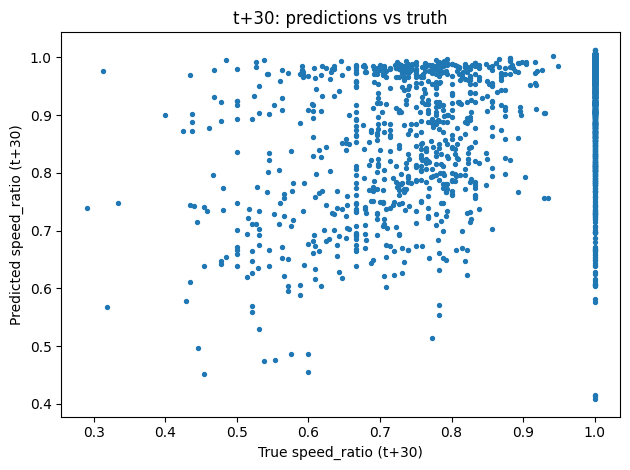

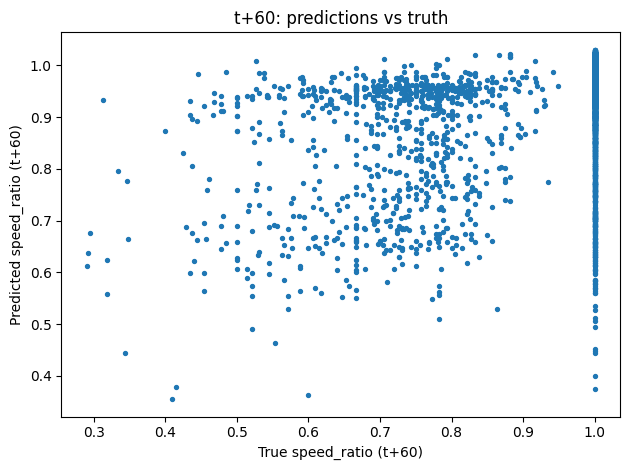

In [15]:
plt.figure()
plt.scatter(y_test_30, pred_30, s=8)
plt.xlabel("True speed_ratio (t+30)")
plt.ylabel("Predicted speed_ratio (t+30)")
plt.title("t+30: predictions vs truth")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test_60, pred_60, s=8)
plt.xlabel("True speed_ratio (t+60)")
plt.ylabel("Predicted speed_ratio (t+60)")
plt.title("t+60: predictions vs truth")
plt.tight_layout()
plt.show()
